# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 1. Initial Data Cleaning
- Step 1: due to the large volume of original data, load the first 100000 observations of the population data before building an ETL function that cleans the real data.

In [2]:
# load in the first 100K observations of the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', nrows= 100000)


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


## Part 1: Data Mining
- Develop a data cleaning pipeline using the azdias data

First, load the dataset of attribute info

In [4]:
## the attributes data
attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols = [1,2,3,4])
attributes.fillna(method = 'ffill', inplace = True)
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


#### Missing Values
According to the attribute values table, some missing values are not encoded as NA. They have other values like -1.

In [5]:
## to take care of missing values - the word 'unknown'
attr_missing = attributes[attributes['Meaning'] == 'unknown']
attr_missing.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


In [6]:
unknown_values = []
for val in attr_missing.Value:
    ## evaluate whether missing 'value' is an integer (one digit)
    if isinstance(val, int):
        unknown_values.append([val])
    ## evaluate whether attribute has more than one value (a string object in the dataframe)
    elif isinstance(val, str):
        split_list = val.split(',')
        int_list = [int(x) for x in split_list]
        unknown_values.append(int_list)

unknown_dict = {}
for attr, value_list in zip(attr_missing.Attribute, unknown_values):
    unknown_dict[attr] = value_list

In [7]:
unknown_dict

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_AUTOQUOT': [-1, 9],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FRAU': [-1, 9],
 'KB

In [8]:
azdias_clean = azdias.copy()
azdias_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [9]:
## use dictionary to replace missing values with NaN
for key in unknown_dict:
    for x in unknown_dict[key]:
        try:
            azdias_clean[key] = azdias_clean[key].replace(x, np.nan)
            
        except:
            ## print columns that are in the attribute list but not on the data
            print(key)
            continue

BIP_FLAG
CAMEO_DEUINTL_2015
D19_KK_KUNDENTYP
GEOSCORE_KLS7
GEOSCORE_KLS7
HAUSHALTSSTRUKTUR
HAUSHALTSSTRUKTUR
KBA13_CCM_1400_2500
SOHO_FLAG
WACHSTUMSGEBIET_NB
WACHSTUMSGEBIET_NB


In [10]:
azdias_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [11]:
## how many missing values are there?

attr_miss = pd.DataFrame(azdias_clean.isnull().mean() * 100, columns = ['pct_miss'])
attr_miss.head()

,pct_miss
LNR,0.000
AGER_TYP,76.222
AKT_DAT_KL,8.385
ALTER_HH,8.385
ALTER_KIND1,90.908


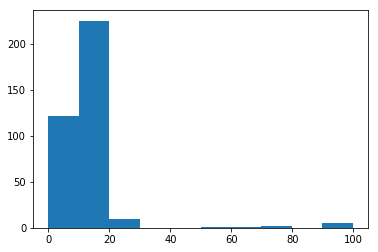

In [12]:
plt.hist(attr_miss['pct_miss']);

- Drop all columns with over 40% of data missing

In [13]:
miss_cols = attr_miss[attr_miss['pct_miss'] > 40]
drop_cols = miss_cols.index
drop_cols

Index(['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ'],
      dtype='object')

In [14]:
azdias_clean.drop(columns = list(drop_cols), inplace = True)
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [15]:
obs_miss = pd.DataFrame(azdias_clean.isnull().mean(axis = 1) * 100, columns = ['pct_miss'])
obs_miss.head()


,pct_miss
0,69.747899
1,2.521008
2,0.000000
3,1.120448
4,0.000000


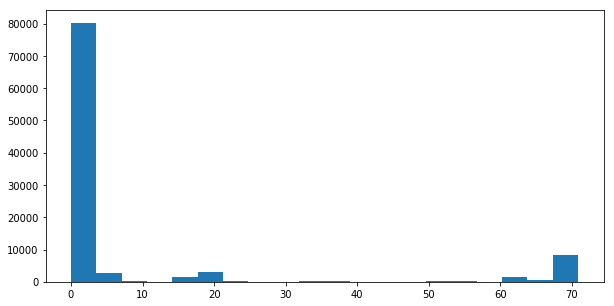

In [16]:
plt.figure(figsize = (10, 5))
plt.hist(obs_miss['pct_miss'], bins = 20);

In [17]:
obs_miss.shape

(100000, 1)

In [18]:
(obs_miss['pct_miss'] > 25).sum()

11881

In [19]:
## how many observations contain more than half missing data?
(obs_miss['pct_miss'] > 50).sum() / azdias_clean.shape[0]

0.11246

In [20]:
miss_50 = obs_miss[obs_miss['pct_miss'] > 50]
miss_50_idxs = list(miss_50.index)

In [21]:
len(miss_50_idxs)

11246

In [22]:
azdias_clean.drop(index= miss_50_idxs, inplace = True)
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


#### Categorical Variables

In [23]:
## investigate the datatypes
azdias_types = pd.DataFrame(azdias_clean.dtypes, columns = ['dtype'])

## get categorical variables
azdias_objects = azdias_types[azdias_types['dtype'] == 'object']
cat_variables = azdias_objects.index.tolist()

In [24]:
azdias_cat = azdias_clean[cat_variables]
azdias_cat.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W


In [25]:
azdias_cat.nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               2467
OST_WEST_KZ                    2
dtype: int64

- `CAMEO_DEU_2015` and `CAMEO_INTL_2015` could be split in two and dummied - consult my previous project or feature information
- `CAMEO_DEUG_2015` could be converted into integers
- `EINGEFUEGT_AM` should be dropped as it contains dates and does not seem important
- `D19_LETZTER_KAUF_BRANCHE` should be dropped since there is information about D19 features and this one is not in the feature dictionary and it does not contain entries similar to any of the D19 features.
- `OST_WEST_KZ` should be dummied (W = 1, O = 0)

In [26]:
## split into wealth and life stage
azdias_clean['CAMEO_DEU_2015'] = azdias_clean['CAMEO_DEU_2015'].replace('XX', np.nan)
azdias_clean['WEALTH_DEU_2015'] = azdias_clean['CAMEO_DEU_2015'].str[0]
azdias_clean['LIFE_STAGE_DEU_2015'] = azdias_clean['CAMEO_DEU_2015'].str[1]

azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,11.0,10.0,3.0,9.0,4.0,5,2,1,8,A
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,9.0,6.0,3.0,9.0,2.0,5,2,3,4,C
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,10.0,11.0,NaN,9.0,7.0,3,2,4,2,A
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,5.0,4.0,2.0,9.0,3.0,4,1,3,6,B
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,7.0,4.0,6.0,9.0,7.0,4,2,1,8,C


In [27]:
## replace 'X' with NaN
azdias_clean['CAMEO_INTL_2015'] = azdias_clean['CAMEO_INTL_2015'].replace('XX', np.nan)
azdias_clean['WEALTH_INTL_2015'] = azdias_clean['CAMEO_INTL_2015'].astype(str).str[0]
azdias_clean['WEALTH_INTL_2015'] = azdias_clean['WEALTH_INTL_2015'].replace('n', np.nan)

azdias_clean['LIFE_STAGE_INTL_2015'] = azdias_clean['CAMEO_INTL_2015'].astype(str).str[1]
azdias_clean['LIFE_STAGE_INTL_2015'] = azdias_clean['LIFE_STAGE_INTL_2015'].replace('a', np.nan)
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,3.0,9.0,4.0,5,2,1,8,A,5,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,3.0,9.0,2.0,5,2,3,4,C,2,4
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,NaN,9.0,7.0,3,2,4,2,A,1,2
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,9.0,3.0,4,1,3,6,B,4,3
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,6.0,9.0,7.0,4,2,1,8,C,5,4


In [28]:

## replace value X for NaN and covert to float
azdias_clean['CAMEO_DEUG_2015'] = azdias_clean['CAMEO_DEUG_2015'].replace('X', np.nan)
azdias_clean['CAMEO_DEUG_2015'] = azdias_clean['CAMEO_DEUG_2015'].astype(float)

azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,3.0,9.0,4.0,5,2,1,8,A,5,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,3.0,9.0,2.0,5,2,3,4,C,2,4
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,NaN,9.0,7.0,3,2,4,2,A,1,2
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,9.0,3.0,4,1,3,6,B,4,3
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,6.0,9.0,7.0,4,2,1,8,C,5,4


- Modify the `PRAEGENDE_JUGENDJAHRE` feature such that it contains a person's decade, 'avantgarde' and 'mainstream'

In [29]:
# temporally change nan values to 0 so that a for loop changes it back
azdias_clean['PRAEGENDE_JUGENDJAHRE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].fillna(0)
decades_p_j = {0: np.nan, 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60,
               7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13:80, 14:90, 15:90}

## create decade (interval), movement (binary)
decade = []
for x in azdias_clean['PRAEGENDE_JUGENDJAHRE']:
    decade.append(decades_p_j[x])

## add decade variable to dataframe
azdias_clean['DECADE'] = decade

azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,DECADE
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,9.0,4.0,5,2,1,8,A,5,1,90.0
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,9.0,2.0,5,2,3,4,C,2,4,90.0
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,9.0,7.0,3,2,4,2,A,1,2,70.0
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,9.0,3.0,4,1,3,6,B,4,3,70.0
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,9.0,7.0,4,2,1,8,C,5,4,50.0


In [30]:
# variable: dimension - list of values
## Movement - Mainstream: [1, 3, 5, 8, 10, 12, 14]
## Movement - Avantgarde: [2, 4, 6, 7, 9, 11, 13, 15]

mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

movement = [] ## movement -> 1: mainstream, 0: avantgarde
for x in azdias_clean['PRAEGENDE_JUGENDJAHRE']:
    if x in mainstream:
        movement.append(1)
    elif x in avantgarde:
        movement.append(0)
    else:
        movement.append(np.nan)
        
azdias_clean['MOVEMENT_MAINSTREAM'] = movement
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,DECADE,MOVEMENT_MAINSTREAM
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,5,2,1,8,A,5,1,90.0,1.0
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,5,2,3,4,C,2,4,90.0,0.0
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,7.0,3,2,4,2,A,1,2,70.0,1.0
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,3.0,4,1,3,6,B,4,3,70.0,1.0
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,7.0,4,2,1,8,C,5,4,50.0,1.0


In [31]:
## drop the variable
azdias_clean.drop(columns = ['LNR', 'PRAEGENDE_JUGENDJAHRE', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM'], inplace = True)
azdias_clean.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,DECADE,MOVEMENT_MAINSTREAM
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,5,2,1,8,A,5,1,90.0,1.0
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,5,2,3,4,C,2,4,90.0,0.0
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,7.0,3,2,4,2,A,1,2,70.0,1.0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,3.0,4,1,3,6,B,4,3,70.0,1.0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,7.0,4,2,1,8,C,5,4,50.0,1.0


#### Fill in Missing Values
- For this analysis, fill in missing values userg forward and backward fill

In [32]:
df_clean_fill = azdias_clean.ffill(axis = 'rows')
df_clean_fill.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,DECADE,MOVEMENT_MAINSTREAM
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,5,2,1,8,A,5,1,90.0,1.0
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,5,2,3,4,C,2,4,90.0,0.0
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,7.0,3,2,4,2,A,1,2,70.0,1.0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,3.0,4,1,3,6,B,4,3,70.0,1.0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,7.0,4,2,1,8,C,5,4,50.0,1.0


In [33]:
df_clean_fill = df_clean_fill.bfill(axis = 'rows')
df_clean_fill.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,DECADE,MOVEMENT_MAINSTREAM
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,5,2,1,8,A,5,1,90.0,1.0
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,5,2,3,4,C,2,4,90.0,0.0
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,7.0,3,2,4,2,A,1,2,70.0,1.0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,3.0,4,1,3,6,B,4,3,70.0,1.0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,7.0,4,2,1,8,C,5,4,50.0,1.0


In [34]:
df_clean_fill.isnull().sum().sum()

0

### Make Dummy Variables

In [35]:
## make dummy variables
dum_features = ['WEALTH_DEU_2015', 'LIFE_STAGE_DEU_2015', 'WEALTH_INTL_2015', 'LIFE_STAGE_INTL_2015', 'OST_WEST_KZ', 'DECADE']

azdias_clean_dum = pd.get_dummies(df_clean_fill, columns = dum_features, drop_first= True)

azdias_clean_dum.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,1,0,1,0,0,0,0,1
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1,0,0,0,1,0,0,1,0,0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,1,0,0,1,0,0,1,0,0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,0,1,0,1,1,0,0,0,0


In [36]:
azdias_clean_dum.shape

(88754, 378)

### 2. Cleaning Pipeline

In [37]:
def clean_data(df):
    
    ## 1 - load the attributes data
    print('Step 1 of 7')
    attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols = [1,2,3,4])
    ## fill in missing values
    attributes.fillna(method = 'ffill', inplace = True)
    
    ## get unknown values from the attributes table
    attr_missing = attributes[attributes['Meaning'] == 'unknown']
    
    
    ## 2 - Modify missing values
    print('Step 2 of 7')
    unknown_values = []
    for val in attr_missing.Value:
        ## evaluate whether missing 'value' is an integer (one digit)
        if isinstance(val, int):
            unknown_values.append([val])
        ## evaluate whether attribute has more than one value (a string object in the dataframe)
        elif isinstance(val, str):
            split_list = val.split(',')
            int_list = [int(x) for x in split_list]
            unknown_values.append(int_list)
            
    ## create dictionary of missing values
    unknown_dict = {}
    for attr, value_list in zip(attr_missing.Attribute, unknown_values):
        unknown_dict[attr] = value_list
        
    ## use dictionary to replace missing values with NaN
    df_clean = df.copy()
    
    for key in unknown_dict:
        for x in unknown_dict[key]:
            try:
                df_clean[key] = df_clean[key].replace(x, np.nan)

            except:
                ## move on for columns that are in the attribute list but not on the data
                continue
    
    ## 3 - Handle missing values
    print('Step 3 of 7')
    ## list columns by missing data percentage
    attr_miss = pd.DataFrame(df_clean.isnull().mean() * 100, columns = ['pct_miss'])
    miss_cols = attr_miss[attr_miss['pct_miss'] > 40].index
    
    ## drop columns with over 40% data missing
    df_clean.drop(columns = list(miss_cols), inplace = True)  
    
    ## list rows by missing data percentage
    miss_obs = pd.DataFrame(df_clean.isnull().mean(axis = 1) * 100, columns = ['pct_miss'])

    
    ## rows that have over half of data missing
    miss_50 = miss_obs[miss_obs['pct_miss'] > 50]

    ## drop the listed rows
    df_clean.drop(index= list(miss_50.index), inplace = True)
    
    
    ## 4 - Modify categorical variables
    print('Step 4 of 7')
    df_clean['CAMEO_DEU_2015'] = df_clean['CAMEO_DEU_2015'].replace('XX', np.nan)
    df_clean['WEALTH_DEU_2015'] = df_clean['CAMEO_DEU_2015'].str[0]
    df_clean['LIFE_STAGE_DEU_2015'] = df_clean['CAMEO_DEU_2015'].str[1]
    
    ## replace 'X' with NaN
    df_clean['CAMEO_INTL_2015'] = df_clean['CAMEO_INTL_2015'].replace('XX', np.nan)
    df_clean['WEALTH_INTL_2015'] = df_clean['CAMEO_INTL_2015'].astype(str).str[0]
    df_clean['WEALTH_INTL_2015'] = df_clean['WEALTH_INTL_2015'].replace('n', np.nan)

    df_clean['LIFE_STAGE_INTL_2015'] = df_clean['CAMEO_INTL_2015'].astype(str).str[1]
    df_clean['LIFE_STAGE_INTL_2015'] = df_clean['LIFE_STAGE_INTL_2015'].replace('a', np.nan)
    
    ## replace value X for NaN and covert to float
    df_clean['CAMEO_DEUG_2015'] = df_clean['CAMEO_DEUG_2015'].replace('X', np.nan)
    df_clean['CAMEO_DEUG_2015'] = df_clean['CAMEO_DEUG_2015'].astype(float)
    
    ## 5 - Modify other variables
    print('Step 5 of 7')
    # temporally change nan values to 0 so that a for loop changes it back
    df_clean['PRAEGENDE_JUGENDJAHRE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].fillna(0)
    decades_p_j = {0: np.nan, 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60,
                   7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13:80, 14:90, 15:90}

    ## create decade (interval), movement (binary)
    decade = []
    for x in df_clean['PRAEGENDE_JUGENDJAHRE']:
        decade.append(decades_p_j[x])

    ## add decade variable to dataframe
    df_clean['DECADE'] = decade
    
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

    movement = [] ## movement -> 1: mainstream, 0: avantgarde
    for x in df_clean['PRAEGENDE_JUGENDJAHRE']:
        if x in mainstream:
            movement.append(1)
        elif x in avantgarde:
            movement.append(0)
        else:
            movement.append(np.nan)

    df_clean['MOVEMENT_MAINSTREAM'] = movement
    
    ## drop variables
    df_clean.drop(columns = ['LNR', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'PRAEGENDE_JUGENDJAHRE'], inplace = True)
    
    ## 6 - Fill in missing values
    print('Step 6 of 7')
    df_clean_fill = df_clean.ffill(axis = 'rows')
    df_clean_fill = df_clean_fill.bfill(axis = 'rows')
    
    ## 7 - dummy variables
    print('Step 7 of 7')
    dum_features = ['WEALTH_DEU_2015', 'LIFE_STAGE_DEU_2015', 'WEALTH_INTL_2015', 'LIFE_STAGE_INTL_2015', 'OST_WEST_KZ', 'DECADE']

    df_final = pd.get_dummies(df_clean_fill, columns = dum_features, drop_first= True)
    
    
    return df_final
    
    
    

In [38]:
azdias_cleaned = clean_data(azdias)
azdias_cleaned.head()

Step 1 of 7
Step 2 of 7
Step 3 of 7
Step 4 of 7
Step 5 of 7
Step 6 of 7
Step 7 of 7


,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,1,0,1,0,0,0,0,1
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1,0,0,0,1,0,0,1,0,0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,1,0,0,1,0,0,1,0,0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,0,1,0,1,1,0,0,0,0


In [39]:
azdias_clean_dum.equals(azdias_cleaned)

True

In [40]:
## load the full datasets
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
## clean the data
azdias_cleaned = clean_data(azdias)


Step 1 of 7
Step 2 of 7
Step 3 of 7
Step 4 of 7
Step 5 of 7
Step 6 of 7
Step 7 of 7


In [42]:
azdias_cleaned.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,1,0,1,0,0,0,0,1
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1,0,0,0,1,0,0,1,0,0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,1,0,0,1,0,0,1,0,0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,0,1,0,1,1,0,0,0,0


In [43]:
## load costumers data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
## clean the customers data
customers_cleaned = clean_data(customers)
customers_cleaned.head()

Step 1 of 7
Step 2 of 7
Step 3 of 7
Step 4 of 7
Step 5 of 7
Step 6 of 7
Step 7 of 7


,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,0,1,0,0,1,1,0,0,0,0
2,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,0,0,1,0,1,1,0,0,0,0
3,1.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,1,0,1,0,0,0,0,0
4,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,0,0,0,0,1,0,0,1,0,0
5,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,0,0,1,0,1,1,0,0,0,0


In [45]:
## save the cleaned datasets as CSV files
azdias_cleaned.to_csv('Udacity_AZDIAS_Cleaned.csv', index= False)
customers_cleaned.to_csv('Udacity_CUSTOMERS_Cleaned.csv', index= False)

## Part 2: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Import Packages and Cleaned Data
Since the population data is very large, the process of determining a number of cluster would incvole

In [2]:
## import Part 2 packages
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
## load cleaned data
azdias = pd.read_csv('Udacity_AZDIAS_Cleaned.csv')
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
0,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1
1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,1,0,1,0,0,0,0,1
2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1,0,0,0,1,0,0,1,0,0
3,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,1,0,0,1,0,0,1,0,0
4,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,0,1,0,1,1,0,0,0,0


In [4]:
azdias.shape

(791255, 378)

In [5]:
customers = pd.read_csv('Udacity_CUSTOMERS_Cleaned.csv')
customers.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,0,1,0,0,1,1,0,0,0,0
1,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,0,0,1,0,1,1,0,0,0,0
2,1.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,1,0,1,0,0,0,0,0
3,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,0,0,0,0,1,0,0,1,0,0
4,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,0,0,1,0,1,1,0,0,0,0


In [6]:
## drop columns in customers not present in the demographics
set(list(customers.columns)) - set(list(azdias.columns))

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [7]:
## drop the three variables above form the customer data since there is no detailed info on them
customers.drop(columns = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace = True)
customers.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,0,1,0,0,1,1,0,0,0,0
1,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,0,0,1,0,1,1,0,0,0,0
2,1.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,1,0,1,0,0,0,0,0
3,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,0,0,0,0,1,0,0,1,0,0
4,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,0,0,1,0,1,1,0,0,0,0


In [8]:
## sample the population dataset to the size of customers data in order to get an optimal number of clusters
azdias_sample = azdias.sample(n = round(azdias.shape[0] * 0.1), random_state = 0)
azdias_sample.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
642351,1.0,14.0,14.0,4.0,0.0,1.0,3.0,2.0,0.0,3.0,...,0,0,1,0,1,0,0,1,0,0
276717,1.0,17.0,17.0,1.0,0.0,2.0,2.0,1.0,0.0,2.0,...,0,0,1,0,1,0,0,0,0,1
371324,1.0,0.0,11.0,2.0,0.0,1.0,2.0,2.0,0.0,2.0,...,0,1,0,0,1,0,1,0,0,0
710450,9.0,18.0,18.0,6.0,0.0,0.0,1.0,4.0,0.0,2.0,...,0,0,1,0,1,0,0,0,0,1
126610,4.0,19.0,19.0,9.0,0.0,0.0,0.0,6.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1


In [9]:
azdias_sample.shape

(79126, 378)

In [33]:
def pca_results(num_components, df = azdias_sample, pct_var = 0.85):
    
    ## 1- standardize the data

    sc = StandardScaler()
    df_sc = sc.fit_transform(df)
    
    ## 2- Fit generic PCA and find number of components

    pca = PCA()
    pca_trans = pca.fit_transform(df_sc)
    
    n_comps = len(pca.explained_variance_ratio_)
    values = pca.explained_variance_ratio_
    cum_vals = np.cumsum(values)

    optimal_pct = cum_vals[cum_vals > pct_var][0]
    num_comp = np.where(cum_vals == optimal_pct)[0][0]
    print('{} principal components explain {}% of the data'.format(num_comp, pct_var*100))
    
    ## 3- fit PCA with optimal number of components

    pca = PCA(n_components= num_comp)
    df_pca = pca.fit_transform(df_sc)
    
    ## 4 - Create a dataframe of the component weights

    df_pca_weights = pd.DataFrame(pca.components_.transpose(), index = df.keys(), columns= np.arange(1, num_comp + 1))
    
    ## 5 - plot the weights for the first three components

    for i in range(1, num_components + 1):
        plt.figure(figsize = (14, 7))
        pc_sorted = df_pca_weights.loc[:,i].sort_values(ascending = False)
        
        pc_sliced = pd.DataFrame(pc_sorted.iloc[np.r_[:10, -10:0]])
        
        sns.barplot(data = pc_sliced, y = pc_sliced.index, x = i)
        plt.title('Feature Weights for the Principal Component {}'.format(i))
        
        plt.show()

156 principal components explain 85.0% of the data


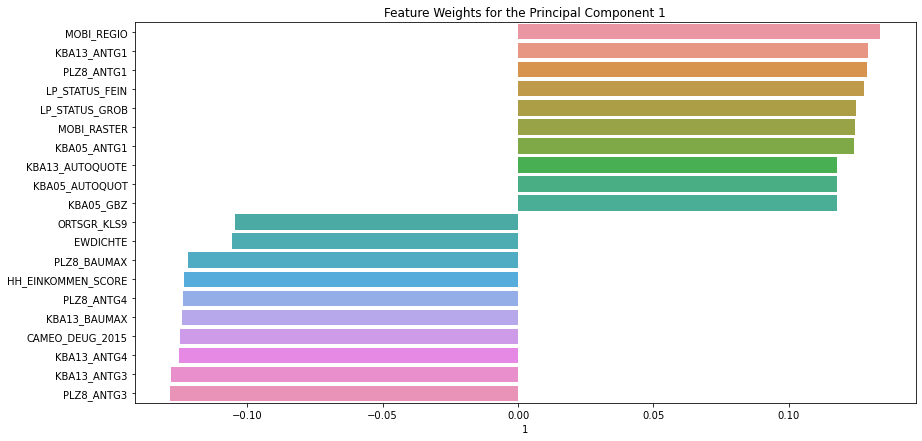

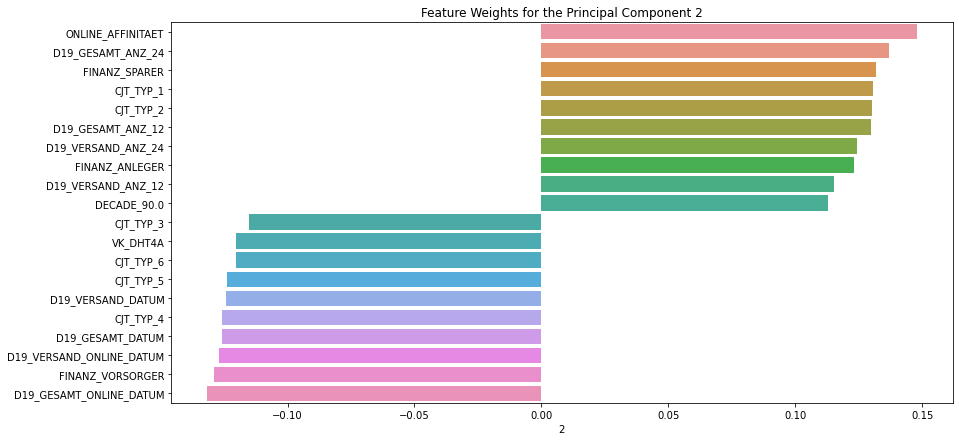

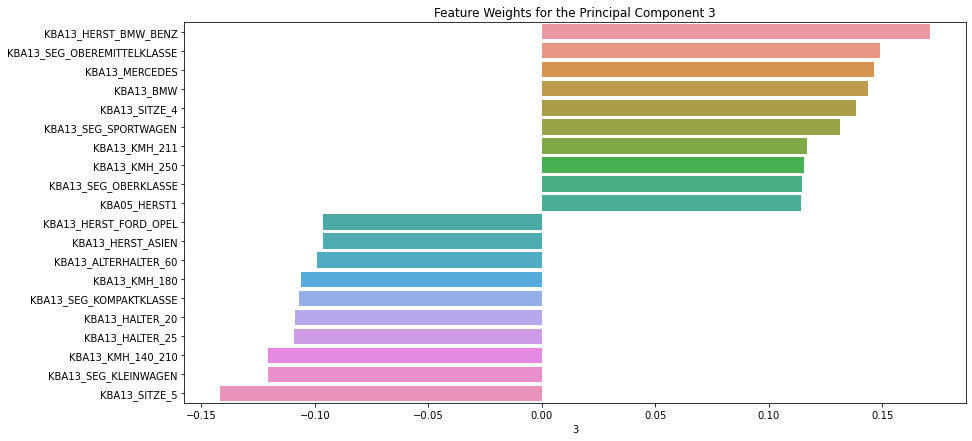

In [34]:
pca_results(3)

160 principal components explain 85.0% of the data


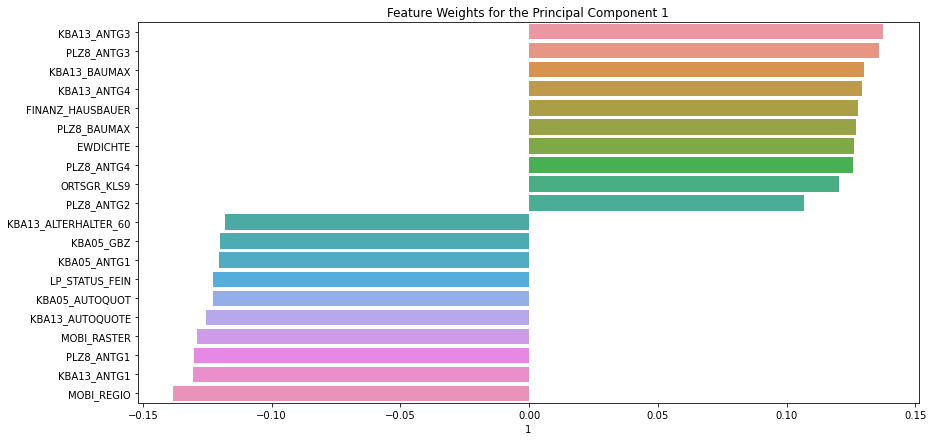

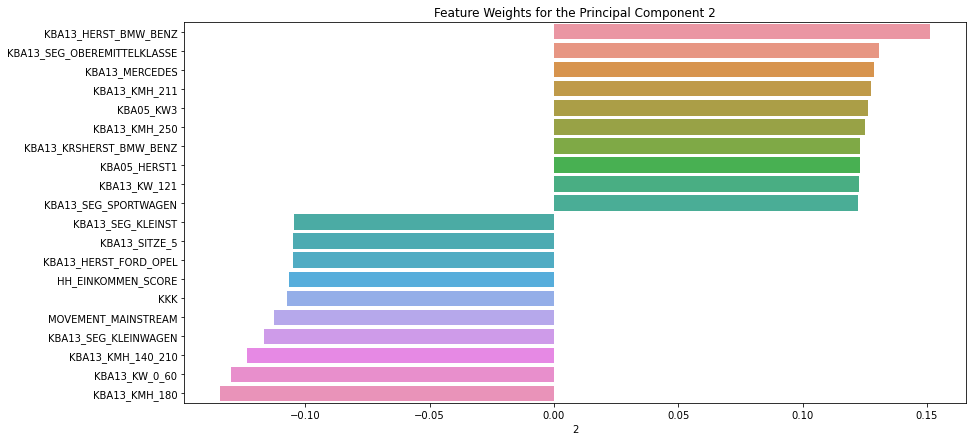

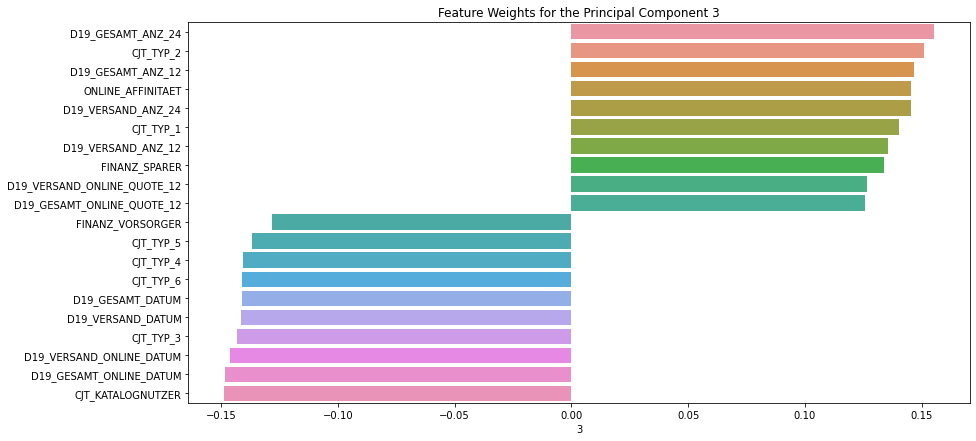

In [35]:
pca_results(3, df = customers)

- Since the number of principal components that explain most of the data's variability for population and the customers data are close to each other, the number to fit both datasets is 160. 

In [11]:
## build a function to determine the optimal number of clusters for the data

## standardize
sc = StandardScaler()
df_sc = sc.fit_transform(azdias_sample)

## PCA Reduction
pca = PCA(n_components= 156)
df_pca = pca.fit_transform(df_sc)


In [15]:
## Find optimal number of clusters via scree plot
s_scores = []
for i in range(2, 12):
    
    print('Fitting', i, 'clusters')
    km_i = KMeans(n_clusters = i)
    
    cluster_label = km_i.fit_predict(df_pca)
    
    sil_score = silhouette_score(df_pca, cluster_label, metric = 'euclidean')

    print(sil_score)
    s_scores.append(sil_score)
    
    

Fitting 2 clusters
0.06584635927301248
Fitting 3 clusters
0.04616196685305533
Fitting 4 clusters
0.03800117236990621
Fitting 5 clusters
0.03286440478966126
Fitting 6 clusters
0.028099966387805264
Fitting 7 clusters
0.027241213619382146
Fitting 8 clusters
0.026149025323531954
Fitting 9 clusters
0.026692209054352833
Fitting 10 clusters
0.02477021910756156
Fitting 11 clusters
0.02512541251421491


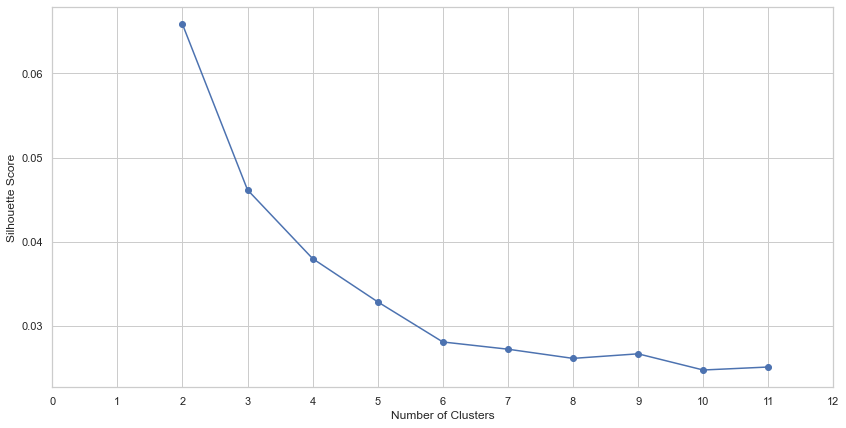

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize= (14, 7))
plt.plot(range(2, 12), s_scores, marker = 'o')
plt.xticks(np.arange(0, 13, 1))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [12]:
## Find optimal number of clusters via scree plot
scores = []
for i in range(1, 21):
    
    print('Fitting', i, 'clusters')
    km_i = KMeans(n_clusters = i, random_state = 0)
    km_i.fit(df_pca)
    
    score = km_i.inertia_
    print('Score: {}'.format(score))
    scores.append(score)

Fitting 1 clusters
Score: 25339849.513591968
Fitting 2 clusters
Score: 23585121.196380164
Fitting 3 clusters
Score: 22772597.480803415
Fitting 4 clusters
Score: 22310948.532547027
Fitting 5 clusters
Score: 21917632.588986058
Fitting 6 clusters
Score: 21597134.76150448
Fitting 7 clusters
Score: 21335281.696932387
Fitting 8 clusters
Score: 21126564.996915672
Fitting 9 clusters
Score: 20957321.616075493
Fitting 10 clusters
Score: 20776746.025374543
Fitting 11 clusters
Score: 20650268.194709335
Fitting 12 clusters
Score: 20534256.812879577
Fitting 13 clusters
Score: 20433864.972144652
Fitting 14 clusters
Score: 20340906.752775285
Fitting 15 clusters
Score: 20253386.22451669
Fitting 16 clusters
Score: 20149289.270230167
Fitting 17 clusters
Score: 20080979.712645244
Fitting 18 clusters
Score: 19986819.55372465
Fitting 19 clusters
Score: 19925183.940789506
Fitting 20 clusters
Score: 19862237.131055925


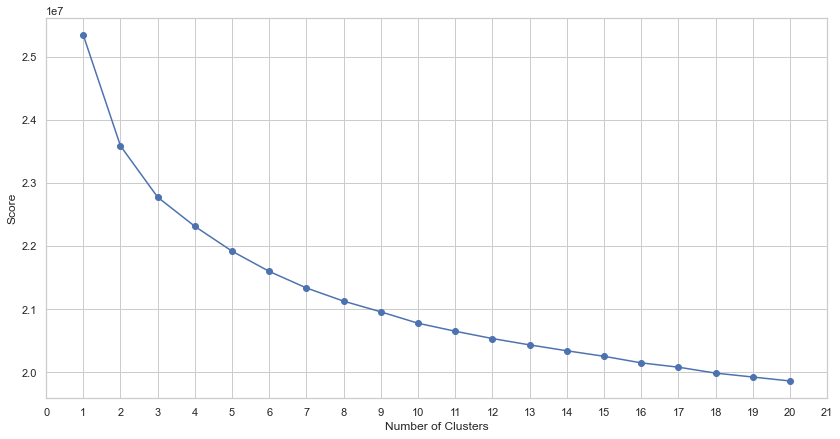

In [14]:
sns.set(style="whitegrid")
plt.figure(figsize= (14, 7))
plt.plot(range(1, 21), scores, marker = 'o')
plt.xticks(np.arange(0, 22, 1))
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

- Use 7 clusters

## Part 3: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')